In [1]:
%load_ext autoreload
%autoreload 2

import time

import torch.nn.functional as F
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
import albumentations as A

from dataset import *

data_valid_p = Path('data/data_valid.json')
data_train_p = Path('data/data_train.json')

/home/tomas/miniconda3/envs/tomlynx/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MAX_STITCHES = 16

import json
with open(data_train_p, 'r') as f:
    data = json.load(f)

image_id = '131'

incision_points = np.array(data[image_id]['incision'], dtype=float)
stitches_points = np.array(data[image_id]['stitches'], dtype=float)

stitches_points2 = np.random.rand(MAX_STITCHES, 2, 2) * 20 - 10 # init with random vals around 0 --scale?
stitches_labels = np.zeros(MAX_STITCHES)
            
# distribute N stitches randomly through the final fixed sized stitches array
N = len(stitches_points)
indices = np.arange(MAX_STITCHES)
np.random.shuffle(indices)
stitches_points2[indices[:N], :] = stitches_points
stitches_labels[indices[:N]] = 1

stitches_points2 = stitches_points2.astype('float32')
stitches_points2 = stitches_points2.reshape([MAX_STITCHES*2, 2])

print(stitches_labels)
stitches_points2


[0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0.]


array([[-1.9511045e+00, -6.7309237e+00],
       [ 7.2217531e+00,  4.4545501e-01],
       [ 2.3019000e+02,  2.1080000e+01],
       [ 2.4622000e+02,  4.3529999e+01],
       [ 6.2521787e+00, -8.1003122e+00],
       [ 3.7573857e+00,  1.8934329e+00],
       [ 7.4976282e+00,  2.3351343e+00],
       [-4.3508778e+00,  1.3438057e+00],
       [ 8.7650002e+01,  2.1440001e+01],
       [ 1.0297000e+02,  5.2790001e+01],
       [ 6.8839650e+00, -8.6372032e+00],
       [ 4.4389982e+00, -7.3491917e+00],
       [ 9.5928049e+00, -5.8140688e+00],
       [-9.5782919e+00, -6.8705301e+00],
       [ 6.3344312e+00, -7.2460942e+00],
       [ 1.9555202e+00,  2.1084764e+00],
       [ 1.3896001e+02,  2.5000000e+01],
       [ 1.5392999e+02,  4.8869999e+01],
       [-7.8615098e+00,  2.9400105e+00],
       [ 6.5654907e+00, -2.6899400e+00],
       [ 8.8376783e-02, -8.0056963e+00],
       [-9.4052982e+00,  6.5912337e+00],
       [ 1.8492999e+02,  2.4290001e+01],
       [ 2.0417000e+02,  4.8520000e+01],
       [ 2.74730

In [9]:
import torch.nn as nn
from torchvision.models import vgg11, VGG11_Weights

backbone_out = 512*4*7

# define model
class Model1(nn.Module):
    def __init__(self, pretrained_model):
        super().__init__()
        self.pretrained = pretrained_model
        # self.fc1 = nn.Linear(backbone_out, 256) # intermediate layer between predictons
        self.fc_points_out = nn.Linear(backbone_out, 96) # 96 coordinates for 16 incisions + 16 stitches
        self.fc_objectness = nn.Linear(backbone_out, 16) # 1 value / stitch
        self.objectness_activation = nn.Sigmoid()
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = nn.functional.relu(self.pretrained(x)) # shape (512, 4, 7) here (for (3,128,255))
        x = torch.flatten(x, start_dim=1)
        x = self.dropout(x)
        # x = nn.functional.relu(self.fc1(x))
        p = torch.tanh(self.fc_points_out(x))
        o = self.objectness_activation(self.fc_objectness(x))
        return p, o
    
# load pretrained vgg + add its first module as conv feature backbone
weights = VGG11_Weights.DEFAULT
model = vgg11(weights=weights)
backbone = list(model.children())[0]
model = Model1(backbone)
print(model)

Model1(
  (pretrained): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fal

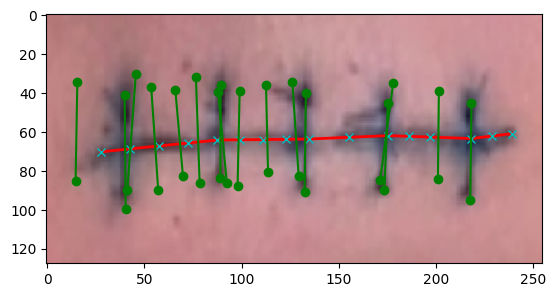

In [10]:
# INIT DATASET AND AUGMENTATIONS

# blur transforms 
transform_blur = A.Compose([
    A.OneOf([
    A.AdvancedBlur(p=0.8),
    A.Blur(p=0.8), 
    A.GaussianBlur(p=0.8),
    A.MedianBlur(p=0.8),
    A.MotionBlur(p=0.8)
  ], p=0.5) 
], keypoint_params=A.KeypointParams(format='xy'))
# spatial transforms
# TODO: add vertical flip ... requires flipping the order of points as well ... separate transform 
# TODO: handle when keypoints outside of img probably condition on len(keypoinst) when forward passing
transform_geom = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.OneOf([
      # TODO: when doing rotation some point easily gets out of picture
      A.ShiftScaleRotate(shift_limit=0, scale_limit=0, rotate_limit=10, p=0.9),
      A.PiecewiseAffine(scale=(0.015, 0.025), p=0.9),
      A.Perspective(scale=(0.01, 0.03), p=0.9)  
    ], p=0.8)
], keypoint_params=A.KeypointParams(format='xy'))

transform_color = A.Compose([
    A.OneOf([
        A.ChannelDropout(p=0.8),
        A.ColorJitter(p=0.8),
        A.HueSaturationValue(p=0.8),
        A.RGBShift(p=0.8),
        A.RandomBrightnessContrast(p=0.8)
    ], p=0.5)
])
transform = A.Compose([transform_color, transform_blur])


train_dataset = ZdoDataset(data_train_p, normalize=True, transform=transform)
val_dataset = ZdoDataset(data_valid_p, normalize=True, transform=transform)


im, points, labeles = val_dataset.__getitem__(10)
# points: 16x2: [incision | stitches]
visualize(im, points[:16,:], points[16:,:], unnormalize=True)

epoch: 0
train-epoch 0 loss: 0.010590142987925431 time: 1.64s
val-epoch 0 loss: 0.03830235600471497 time: 1.78s
epoch: 1
train-epoch 1 loss: 0.010344597800024625 time: 1.57s
val-epoch 1 loss: 0.041032417118549346 time: 1.69s
epoch: 2
train-epoch 2 loss: 0.009593318248617238 time: 1.51s
val-epoch 2 loss: 0.04071999341249466 time: 1.64s
epoch: 3
train-epoch 3 loss: 0.008895810051210996 time: 1.58s
val-epoch 3 loss: 0.0416348323225975 time: 1.71s
epoch: 4
train-epoch 4 loss: 0.008731335016160175 time: 1.55s
val-epoch 4 loss: 0.046013841032981874 time: 1.68s
epoch: 5
train-epoch 5 loss: 0.008352536579658246 time: 1.53s
val-epoch 5 loss: 0.0462590828537941 time: 1.66s
epoch: 6
train-epoch 6 loss: 0.008151161516534871 time: 1.53s
val-epoch 6 loss: 0.04723364561796188 time: 1.70s
epoch: 7
train-epoch 7 loss: 0.007767508898315759 time: 1.57s
val-epoch 7 loss: 0.04705718904733658 time: 1.71s
epoch: 8
train-epoch 8 loss: 0.007404151790100953 time: 1.54s
val-epoch 8 loss: 0.05027879923582077 time

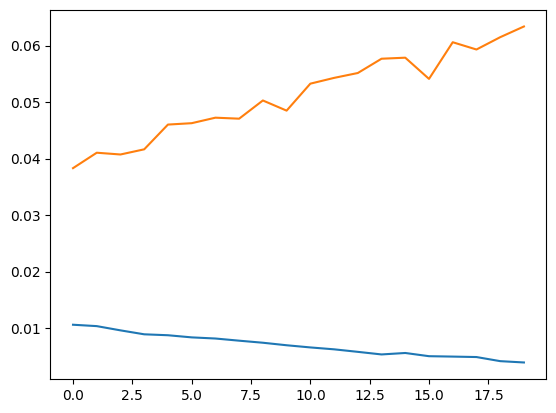

In [13]:
# setup dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloder = DataLoader(val_dataset, batch_size=10, shuffle=True)


# TRAIN!
def train(net, dataloaders, optimizer, loss_det, loss_obj, num_epoch, device, validation=True, freq_print=10):
    net = net.to(device)
    loss_hist = np.ones((num_epoch,2))*np.inf
    a = 0.5
    b = 0.5
    for epoch in range(num_epoch):
        time_start = time.time()
        print(f"epoch: {epoch}")
        for loader_idx, phase in enumerate(dataloaders):
            if phase == 'train':
                net.train()
            else:
                if not validation:
                    break
                net.eval()

            loader = dataloaders[phase]
            running_loss = 0.0
            epoch_loss = 0.0
            # one batch
            for i, d in enumerate(loader, 0):
                inputs, points, labels = d
                points = points.flatten(start_dim=1) # as output of 32 neurons linear layer
                                
                inputs, points, labels = inputs.to(device), points.to(device), labels.to(device)
                
                #zero the grad!
                optimizer.zero_grad()

                out_p, out_o = net(inputs)

                # the stuff
                loss = a*loss_det(out_p, points) + b*loss_obj(out_o, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
         
                # statistics
                running_loss += loss.item()
                epoch_loss += loss.item()

                if i % freq_print == (freq_print-1): 
                    print(f'{phase}: [{epoch + 1}, {i + 1:5d}] loss: {running_loss / freq_print:.3f}')
                    running_loss = 0.0 

            # normalize metrics by the size of data
            epoch_loss /= len(dataloaders[phase].dataset)
            loss_hist[epoch,loader_idx] = epoch_loss
            epoch_time = time.time() - time_start
            print(f"{phase}-epoch {epoch} loss: {epoch_loss} time: {epoch_time:.2f}s")
            
    print("training finished")
    plt.plot(loss_hist)
    
    return loss_hist

# train setup
dataloaders={'train': train_dataloader, 'val':val_dataloder}
num_epoch = 20
# optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
optimizer = optim.AdamW(model.parameters())
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
loss = nn.MSELoss()
loss_objectness = nn.BCELoss()

loss_hist = train(model, dataloaders, optimizer, loss, loss_objectness, num_epoch, device)

TypeError: object of type 'NoneType' has no len()

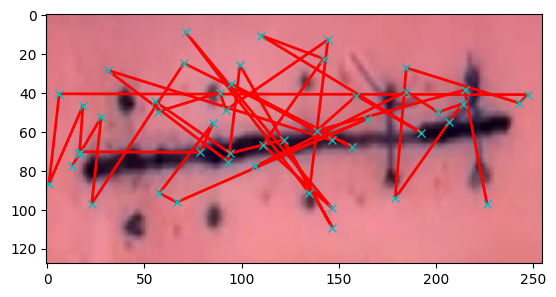

In [238]:
im, points_gt, stitchness_gt = val_dataset.__getitem__(3)
# visualize(im, points, unnormalize=True)

# prediction:
model.eval()
im2 = (im.unsqueeze(0)).to(device)
points_pred, stitchness = model(im2)
points_pred = points_pred.reshape([48,2]).detach().cpu()
visualize(im, points_pred, unnormalize=True)
plt.figure()

In [245]:
stitchness.detach().cpu().numpy()

array([[8.5585860e-05, 7.9233259e-02, 8.3643496e-01, 1.3872398e-01,
        4.0954899e-02, 6.2152588e-01, 2.1976052e-01, 3.8305161e-04,
        9.5107993e-03, 1.9655587e-02, 3.0792912e-02, 4.8273299e-02,
        9.4175749e-03, 1.5045469e-01, 3.5235532e-02, 1.1217728e-04]],
      dtype=float32)

In [246]:
stitchness_gt

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.])

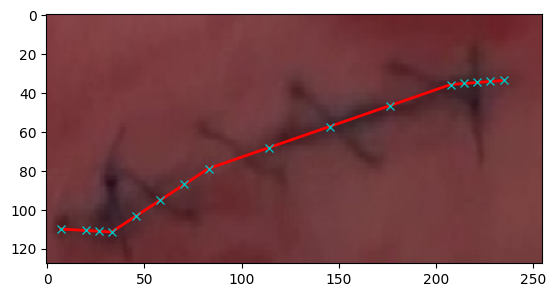

In [6]:
im, incision = train_dataset.get_raw_item('77')
visualize(im, incision)

In [7]:
len(incision)

16

In [12]:
# hmmm
train_ids = list(train_dataset.images.keys())
valid_ids = list(val_dataset.images.keys())

print(f"train size: {len(train_ids)}")
for k in train_ids:
    if k in valid_ids: print("ajaaj")

train size: 116
